In [1]:
import os 
import pandas as pd
import numpy as np 
import seaborn as sns
from PIL import Image 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
label_dic = {
    "0":"No DR",
    "1" : "Mild",
    "2":"Moderate",
    "3":"Severe",
    "4":"Proliferative DR"
}
df_train = pd.read_csv('/kaggle/input/resized-aptos-2019-blindness-detection/resized_2019_aptos/train.csv')
df_test = pd.read_csv('/kaggle/input/resized-aptos-2019-blindness-detection/resized_2019_aptos/test.csv')


In [3]:
print("Training Data Shape : ",df_train.shape)
print("Test Data Shape : ",df_test.shape)
df_train.head()

Training Data Shape :  (3662, 2)
Test Data Shape :  (1928, 1)


id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [4]:
df_train.diagnosis.value_counts()

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [5]:

# Add '.png' extension to id_code
df_train['id_code'] = df_train['id_code'].apply(lambda x: x + ".png")
df_test['id_code'] = df_test['id_code'].apply(lambda x: x + ".png")

# Convert the labels to string
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

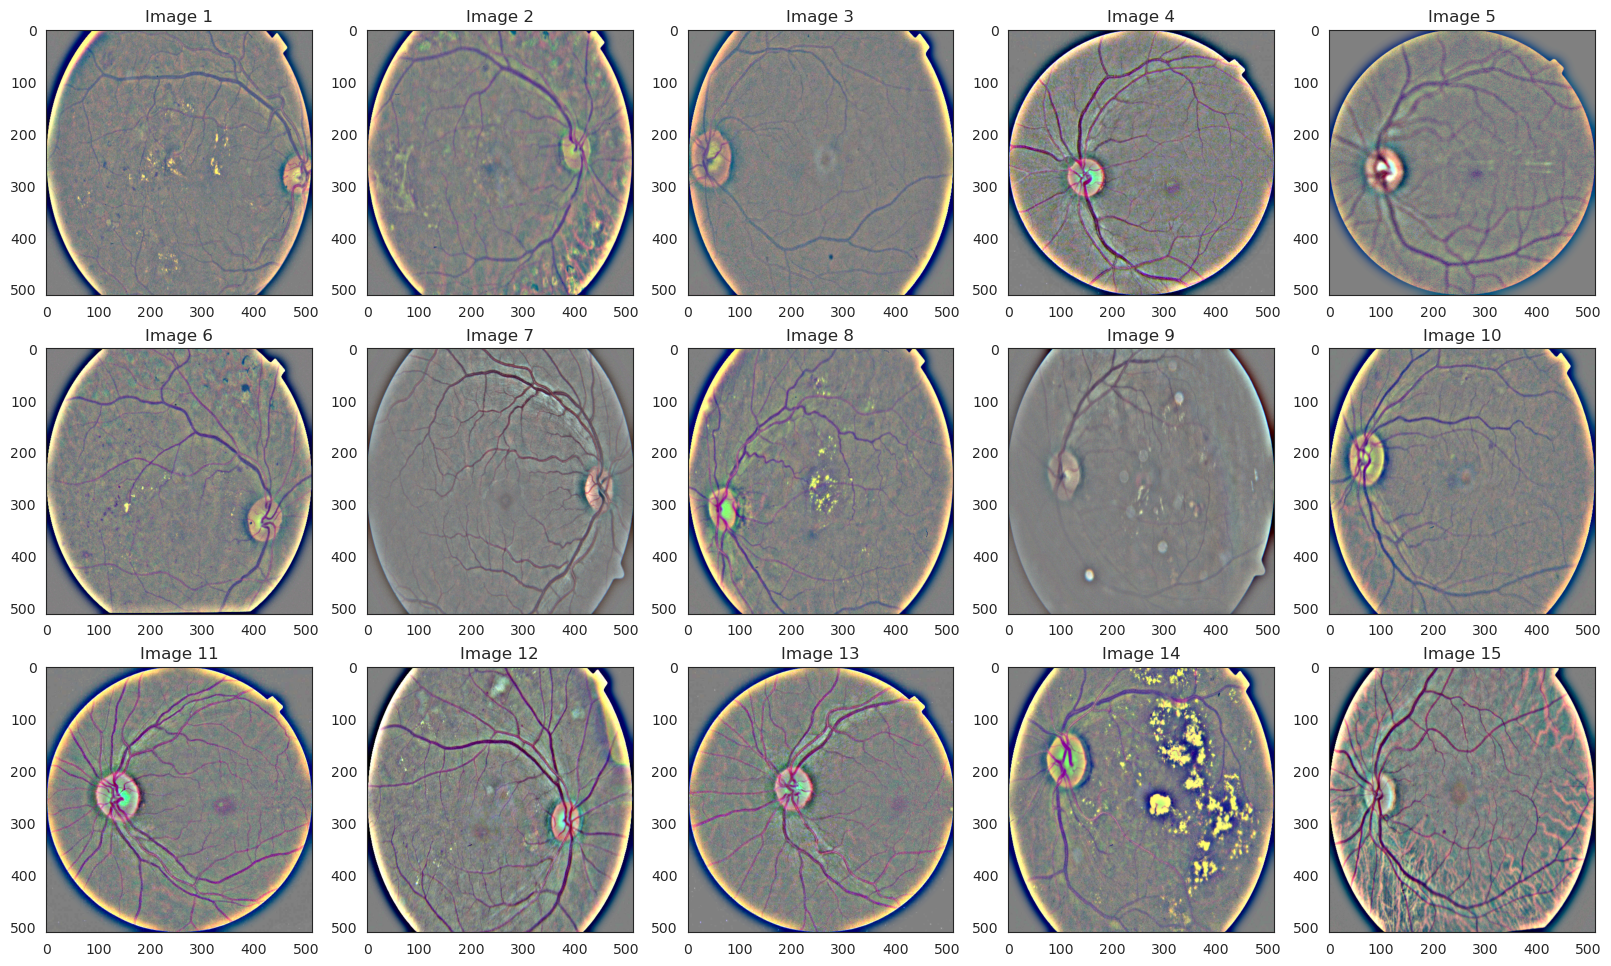

In [30]:
sns.set_style("white")
train = pd.read_csv('/kaggle/input/resized-aptos-2019-blindness-detection/resized_2019_aptos/train.csv')
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread("/kaggle/input/resized-aptos-2019-blindness-detection/resized_2019_aptos/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [6]:
# normalize the images
df_train['diagnosis'] = df_train['diagnosis'].astype('str')

# Split the data
df_train, val_df = train_test_split(df_train, test_size=0.2)

# Generate batches of tensor image data for train and validation
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train,
    directory='/kaggle/input/resized-aptos-2019-blindness-detection/resized_2019_aptos/train_images/',
    x_col='id_code',
    y_col='diagnosis',
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224))

val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory='/kaggle/input/resized-aptos-2019-blindness-detection/resized_2019_aptos/train_images/',
    x_col='id_code',
    y_col='diagnosis',
    batch_size=32,
    class_mode='categorical',
    target_size=(224, 224))

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


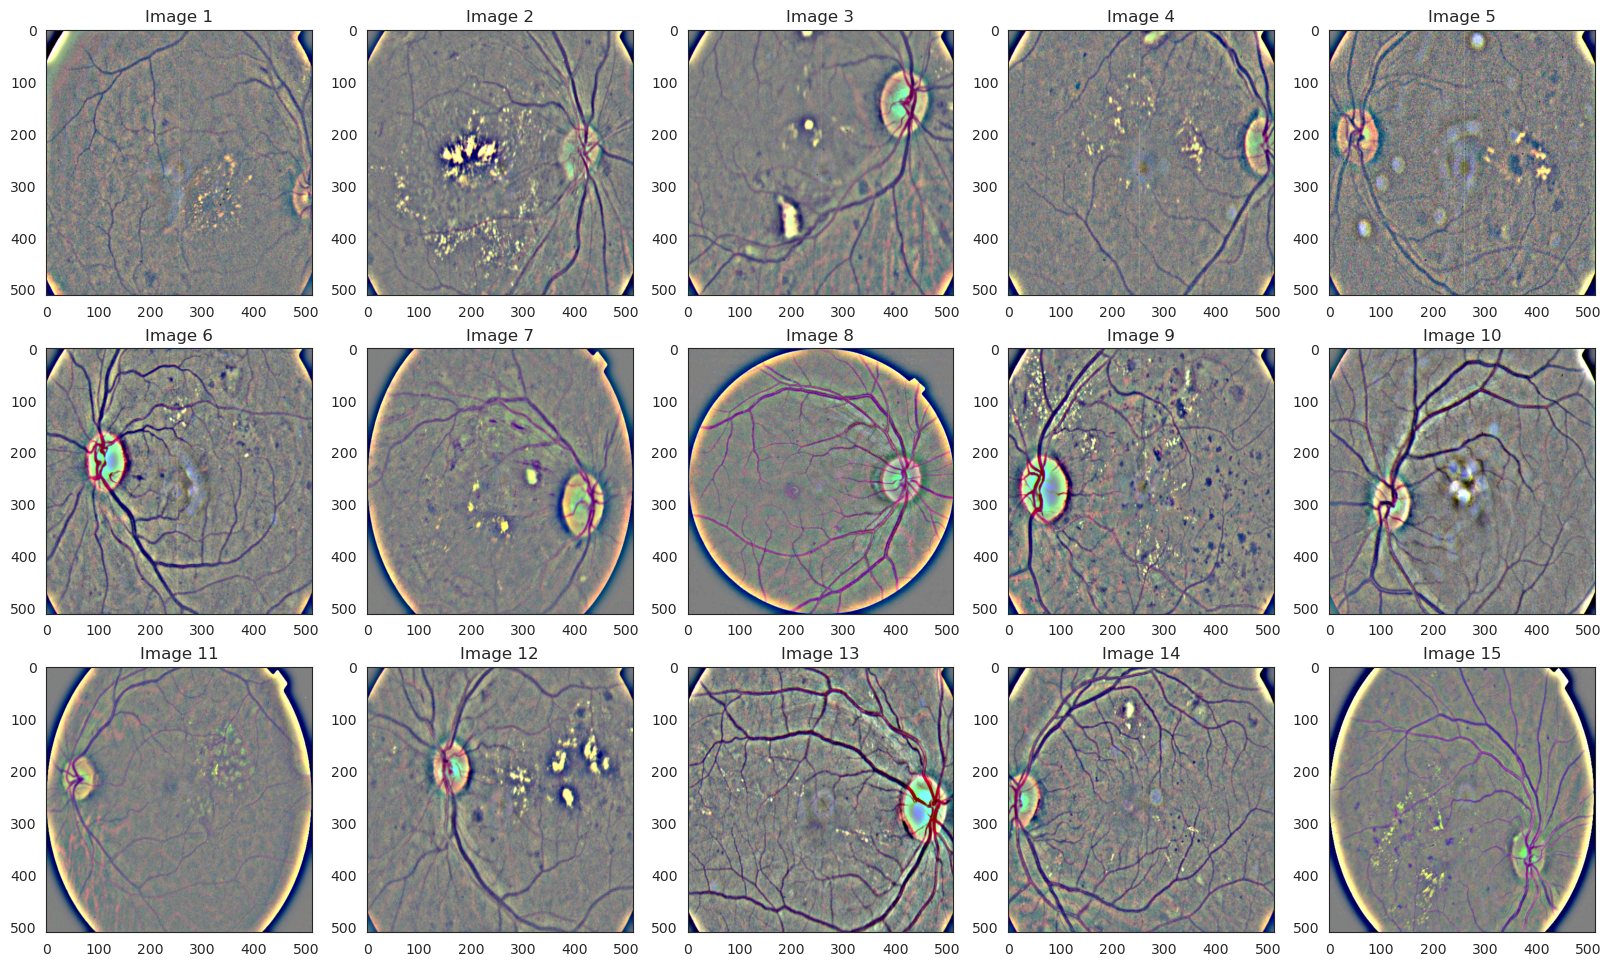

In [32]:
sns.set_style("white")
test = pd.read_csv('/kaggle/input/resized-aptos-2019-blindness-detection/resized_2019_aptos/test.csv')
count = 1
plt.figure(figsize=[20, 20])
for img_name in test['id_code'][:15]:
    img = cv2.imread("/kaggle/input/resized-aptos-2019-blindness-detection/resized_2019_aptos/test_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [17]:
# Get the ResNet50 base model
base_model = ResNet50(include_top=False, pooling='avg')

# Make the base model untrainable
base_model.trainable = False 

# Define the model
model = Sequential([
    base_model,
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
callbacks = [EarlyStopping(patience=3, restore_best_weights=True),
             ModelCheckpoint(filepath='Blindness Detection_model.h5', save_best_only=True)]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    validation_data = val_generator, 
    validation_steps = val_generator.n//val_generator.batch_size,
    epochs = 15,
    callbacks=callbacks)

Epoch 1/15
91/91 [==============================] - 50s 515ms/step - loss: 1.2319 - accuracy: 0.5009 - val_loss: 1.1044 - val_accuracy: 0.5639
Epoch 2/15
91/91 [==============================] - 45s 495ms/step - loss: 1.0478 - accuracy: 0.6579 - val_loss: 1.0044 - val_accuracy: 0.6634
Epoch 3/15
91/91 [==============================] - 45s 495ms/step - loss: 0.9703 - accuracy: 0.6835 - val_loss: 0.9603 - val_accuracy: 0.6676
Epoch 4/15
91/91 [==============================] - 45s 491ms/step - loss: 0.9321 - accuracy: 0.6848 - val_loss: 0.9230 - val_accuracy: 0.6705
Epoch 5/15
91/91 [==============================] - 44s 485ms/step - loss: 0.9046 - accuracy: 0.6924 - val_loss: 0.9130 - val_accuracy: 0.6705
Epoch 6/15
91/91 [==============================] - 45s 497ms/step - loss: 0.8914 - accuracy: 0.6952 - val_loss: 0.8699 - val_accuracy: 0.6861
Epoch 7/15
91/91 [==============================] - 44s 486ms/step - loss: 0.8772 - accuracy: 0.6907 - val_loss: 0.8941 - val_accuracy: 0.6690

In [19]:
loss, accuracy = model.evaluate(val_generator)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

23/23 [==============================] - 9s 370ms/step - loss: 0.8456 - accuracy: 0.6849
Loss: 0.8456374406814575
Accuracy: 0.6848567724227905


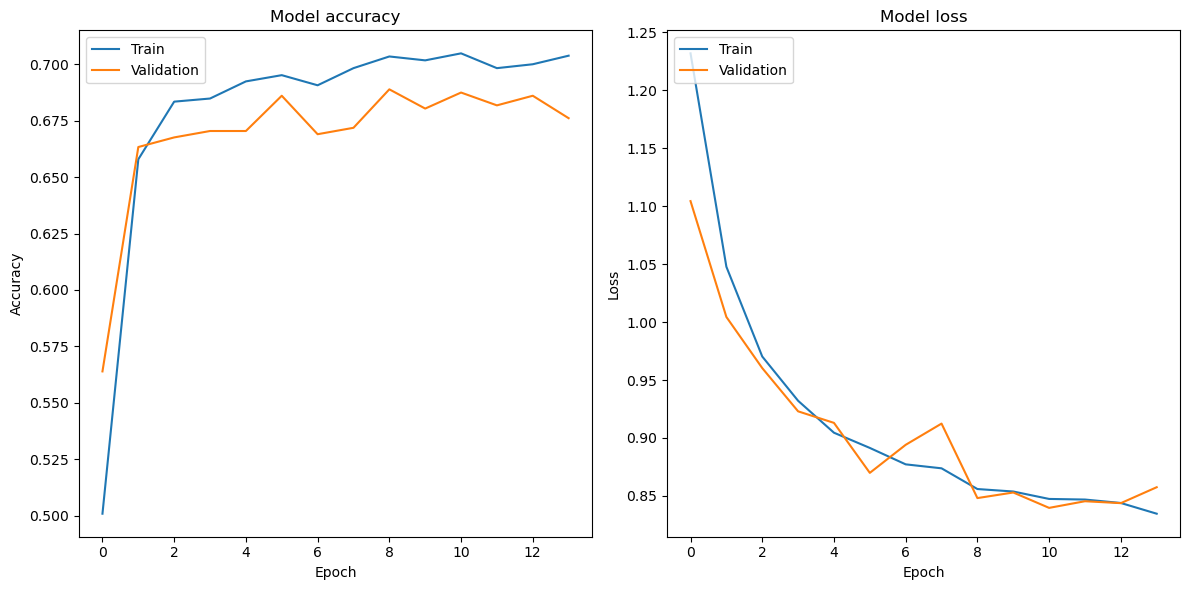

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()